In [ ]:
import tensorflow as tf
import tensorflow.keras.utils
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as k
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from keras.backend import shape
from tensorflow.keras import optimizers
# specifically for cnn
from tensorflow.keras.layers import Dropout, Flatten,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [ ]:
# data visualisation and manipulation
import os
import cv2  
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [ ]:
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [ ]:
#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.        
from tqdm import tqdm        
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from tensorflow.keras.applications.vgg16 import VGG16

## Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(os.listdir('/content/drive/MyDrive/TrashBox_train_set'))

['glass', 'medical', 'e-waste', 'metal', 'paper', 'cardboard', 'Trash Classification.ipynb']


In [ ]:
X=[]
Z=[]
IMG_SIZE=224
cardboard_DIR='/content/drive/MyDrive/TrashBox_train_set/cardboard'
e_waste_DIR='/content/drive/MyDrive/TrashBox_train_set/e-waste'
glass_DIR='/content/drive/MyDrive/TrashBox_train_set/glass'
medical_DIR='/content/drive/MyDrive/TrashBox_train_set/medical'
metal_DIR='/content/drive/MyDrive/TrashBox_train_set/metal'
paper_DIR='/content/drive/MyDrive/TrashBox_train_set/paper'
plastic_DIR='/content/drive/MyDrive/TrashBox_train_set/plastic'

In [ ]:
def assign_label(img,trash_type):
    return trash_type

## Generate Training Data

In [ ]:
def make_train_data(trash_type,DIR):
    for img, count in zip(tqdm(os.listdir(DIR)), range(1, 500)):
        if count > 499:
            break
        try:
            label=assign_label(img,trash_type)
            path = os.path.join(DIR,img)
            img = cv2.imread(path,cv2.IMREAD_UNCHANGED)
            img = cv2.resize(img, (224,224))
            if img.shape == (224, 224, 3):
                X.append(np.array(img))
                Z.append(str(label))
        except:
            continue

In [ ]:
make_train_data('cardboard',cardboard_DIR)
print(len(X))

 60%|█████▉    | 499/833 [00:13<00:08, 37.96it/s]

489


In [ ]:
make_train_data('e_waste',e_waste_DIR)
print(len(X))

 22%|██▏       | 499/2238 [00:42<02:27, 11.76it/s]

968


In [ ]:
make_train_data('glass',glass_DIR)
print(len(X))

 25%|██▍       | 499/2022 [00:48<02:28, 10.25it/s]

1460


In [ ]:
make_train_data('medical',medical_DIR)
print(len(X))

 32%|███▏      | 499/1565 [00:37<01:19, 13.39it/s]

1943


In [ ]:
make_train_data('metal',metal_DIR)
print(len(X))

 24%|██▍       | 499/2064 [00:51<02:41,  9.71it/s]

2409


In [ ]:
make_train_data('paper',paper_DIR)
print(len(X))

 39%|███▉      | 499/1277 [00:15<00:23, 32.96it/s]

2904


In [ ]:
make_train_data('plastic',plastic_DIR)
print(len(X))

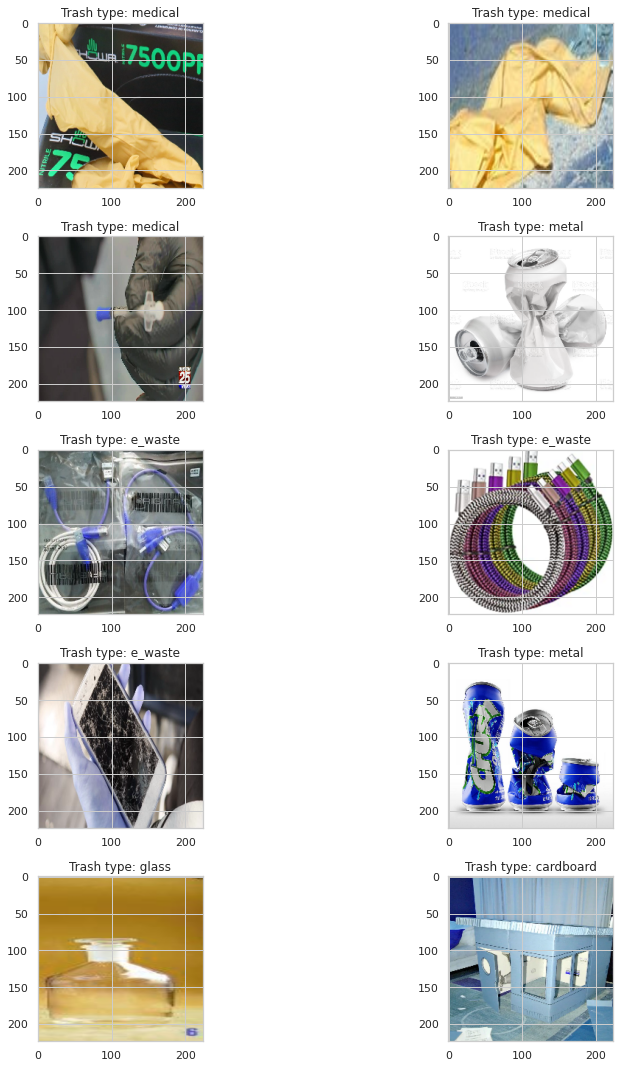

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Trash type: '+Z[l])
 
plt.tight_layout()

# Data Preprocessing

In [ ]:
le=LabelEncoder()
Y=le.fit_transform(Z)
print(list(le.classes_))
Y=to_categorical(Y,7)
X=np.array(X)
X=X/255

['cardboard', 'e_waste', 'glass', 'medical', 'metal', 'paper']


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=42)

In [ ]:

shape(X)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([2904,  224,  224,    3], dtype=int32)>

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

# Models

## Xception

In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

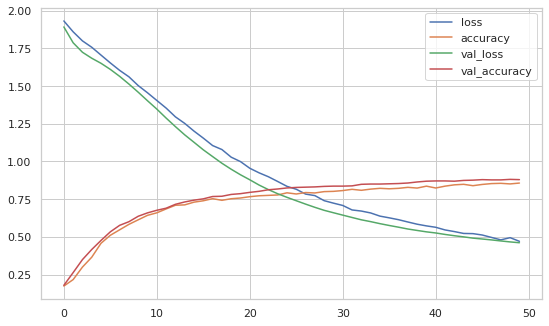

In [ ]:
num_classes = 7
batch_size=32
epochs=50


base_model = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3))
# create a custom top classifier
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x) #Pooling Layer
x = Dense(1024, activation='relu')(x)#Extra layer
predictions = Dense( 7, activation='softmax')(x)#Prediction Layer
model = Model(inputs=base_model.inputs, outputs=predictions)


model.compile(tensorflow.keras.optimizers.SGD(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

History = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
model.save('Xception.h5',include_optimizer=True)


In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

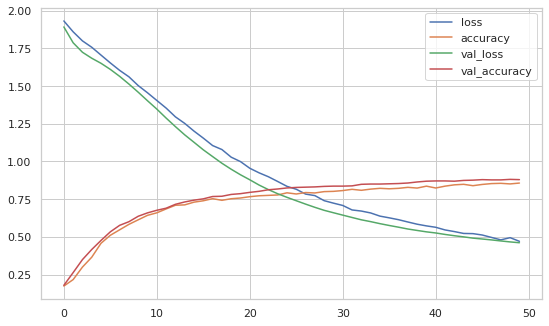

In [ ]:
pd.DataFrame(History.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.show()

# VGG19

In [ ]:
#VGG19=tf.keras.applications.vgg19.VGG19(
    #include_top=True,
    #weights='imagenet',
    #input_shape=(224,224,3),
    #classifier_activation='softmax') #not good


# Resnet, Densenet , MobileNet

In [ ]:
modeldict={
    'ResNet50':tf.keras.applications.ResNet50(
    include_top=True,
    weights='imagenet',
    input_shape=(224,224,3),
    classifier_activation='softmax'),#Needs more epochs i would say 120
    'DenseNet201':tf.keras.applications.DenseNet201(
    include_top=True,
    weights='imagenet',
    input_shape=(224,224,3)),#Needs more epochs i would say 100
    'ResNet152V2':tf.keras.applications.ResNet152V2(
    include_top=True,
    weights='imagenet',
    input_shape=(224,224,3),
    classifier_activation='softmax'),
    'MobileNet':tf.keras.applications.MobileNet(
    include_top=True,
    weights='imagenet',
    input_shape=(224,224,3), #good Perofrmance 120 Epochs is good
    classifier_activation='softmax'),
    'NASNetMobile':tf.keras.applications.NASNetMobile(
    include_top=True,
    weights='imagenet',
    input_shape=(224,224,3)) # good performance 100
}

24240128/24227760 [==============================] - 0s 0us/step


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from google.colab import files


Epoch 1/120
241/241 [==============================] - 94s 333ms/step - loss: 1.9381 - accuracy: 0.2090 - val_loss: 1.9335 - val_accuracy: 0.2636
Epoch 2/120
241/241 [==============================] - 78s 323ms/step - loss: 1.9248 - accuracy: 0.2322 - val_loss: 1.9215 - val_accuracy: 0.2171
Epoch 3/120
241/241 [==============================] - 78s 322ms/step - loss: 1.9127 - accuracy: 0.2303 - val_loss: 1.9089 - val_accuracy: 0.2181
Epoch 4/120
241/241 [==============================] - 79s 328ms/step - loss: 1.9007 - accuracy: 0.2287 - val_loss: 1.8960 - val_accuracy: 0.2253
Epoch 5/120
241/241 [==============================] - 80s 331ms/step - loss: 1.8900 - accuracy: 0.2243 - val_loss: 1.8850 - val_accuracy: 0.2233
Epoch 6/120
241/241 [==============================] - 80s 332ms/step - loss: 1.8798 - accuracy: 0.2237 - val_loss: 1.8751 - val_accuracy: 0.2207
Epoch 7/120
241/241 [==============================] - 80s 333ms/step - loss: 1.8701 - accuracy: 0.2242 - val_loss: 1.8659 -

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

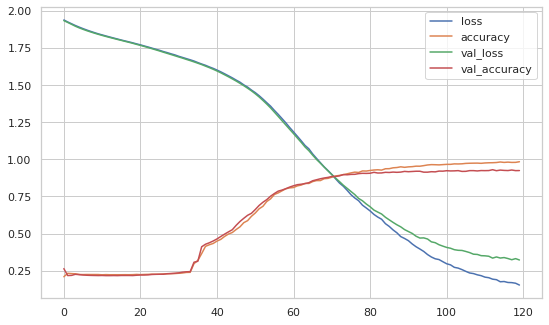

Epoch 1/120
241/241 [==============================] - 109s 378ms/step - loss: 1.9383 - accuracy: 0.2129 - val_loss: 1.9317 - val_accuracy: 0.2021
Epoch 2/120
241/241 [==============================] - 84s 346ms/step - loss: 1.9246 - accuracy: 0.2299 - val_loss: 1.9188 - val_accuracy: 0.2258
Epoch 3/120
241/241 [==============================] - 82s 341ms/step - loss: 1.9120 - accuracy: 0.2396 - val_loss: 1.9068 - val_accuracy: 0.2202
Epoch 4/120
241/241 [==============================] - 81s 337ms/step - loss: 1.9000 - accuracy: 0.2392 - val_loss: 1.8955 - val_accuracy: 0.2253
Epoch 5/120
241/241 [==============================] - 82s 340ms/step - loss: 1.8889 - accuracy: 0.2398 - val_loss: 1.8850 - val_accuracy: 0.2253
Epoch 6/120
241/241 [==============================] - 84s 347ms/step - loss: 1.8785 - accuracy: 0.2386 - val_loss: 1.8753 - val_accuracy: 0.2295
Epoch 7/120
241/241 [==============================] - 83s 343ms/step - loss: 1.8690 - accuracy: 0.2368 - val_loss: 1.8663 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

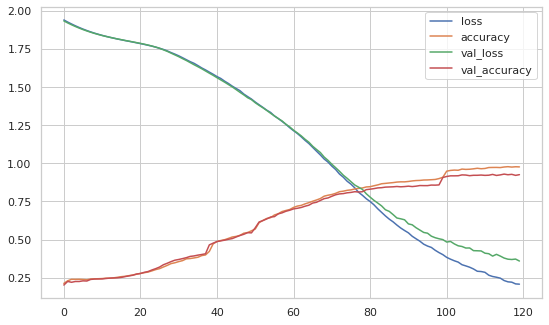

Epoch 1/120
241/241 [==============================] - 102s 370ms/step - loss: 1.9384 - accuracy: 0.1858 - val_loss: 1.9312 - val_accuracy: 0.2036
Epoch 2/120
241/241 [==============================] - 84s 346ms/step - loss: 1.9249 - accuracy: 0.1989 - val_loss: 1.9187 - val_accuracy: 0.2083
Epoch 3/120
241/241 [==============================] - 83s 343ms/step - loss: 1.9123 - accuracy: 0.2045 - val_loss: 1.9069 - val_accuracy: 0.2016
Epoch 4/120
241/241 [==============================] - 85s 351ms/step - loss: 1.9004 - accuracy: 0.2156 - val_loss: 1.8959 - val_accuracy: 0.2119
Epoch 5/120
241/241 [==============================] - 84s 346ms/step - loss: 1.8894 - accuracy: 0.2213 - val_loss: 1.8857 - val_accuracy: 0.2119
Epoch 6/120
241/241 [==============================] - 85s 350ms/step - loss: 1.8792 - accuracy: 0.2231 - val_loss: 1.8762 - val_accuracy: 0.2124
Epoch 7/120
241/241 [==============================] - 85s 350ms/step - loss: 1.8699 - accuracy: 0.2225 - val_loss: 1.8675 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

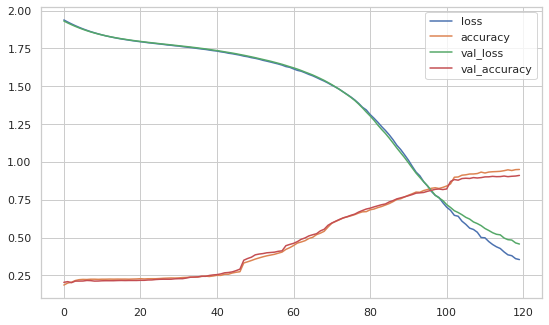

Epoch 1/120
241/241 [==============================] - 80s 323ms/step - loss: 1.9373 - accuracy: 0.2152 - val_loss: 1.9299 - val_accuracy: 0.2543
Epoch 2/120
241/241 [==============================] - 76s 315ms/step - loss: 1.9238 - accuracy: 0.2494 - val_loss: 1.9173 - val_accuracy: 0.2620
Epoch 3/120
241/241 [==============================] - 76s 313ms/step - loss: 1.9115 - accuracy: 0.2545 - val_loss: 1.9056 - val_accuracy: 0.2620
Epoch 4/120
241/241 [==============================] - 77s 319ms/step - loss: 1.9001 - accuracy: 0.2500 - val_loss: 1.8946 - val_accuracy: 0.2615
Epoch 5/120
241/241 [==============================] - 77s 318ms/step - loss: 1.8891 - accuracy: 0.2534 - val_loss: 1.8844 - val_accuracy: 0.2615
Epoch 6/120
241/241 [==============================] - 77s 318ms/step - loss: 1.8793 - accuracy: 0.2497 - val_loss: 1.8750 - val_accuracy: 0.2574
Epoch 7/120
241/241 [==============================] - 76s 316ms/step - loss: 1.8700 - accuracy: 0.2481 - val_loss: 1.8662 -

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

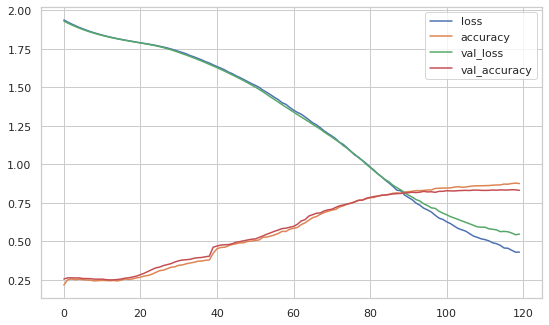

Epoch 1/120
241/241 [==============================] - 110s 365ms/step - loss: 1.9391 - accuracy: 0.1832 - val_loss: 1.9328 - val_accuracy: 0.2005
Epoch 2/120
241/241 [==============================] - 82s 340ms/step - loss: 1.9255 - accuracy: 0.2220 - val_loss: 1.9196 - val_accuracy: 0.2217
Epoch 3/120
241/241 [==============================] - 81s 335ms/step - loss: 1.9129 - accuracy: 0.2257 - val_loss: 1.9075 - val_accuracy: 0.2202
Epoch 4/120
241/241 [==============================] - 82s 337ms/step - loss: 1.9012 - accuracy: 0.2243 - val_loss: 1.8962 - val_accuracy: 0.2222
Epoch 5/120
241/241 [==============================] - 82s 341ms/step - loss: 1.8903 - accuracy: 0.2303 - val_loss: 1.8858 - val_accuracy: 0.2227
Epoch 6/120
241/241 [==============================] - 81s 336ms/step - loss: 1.8802 - accuracy: 0.2286 - val_loss: 1.8761 - val_accuracy: 0.2233
Epoch 7/120
241/241 [==============================] - 81s 334ms/step - loss: 1.8707 - accuracy: 0.2409 - val_loss: 1.8671 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

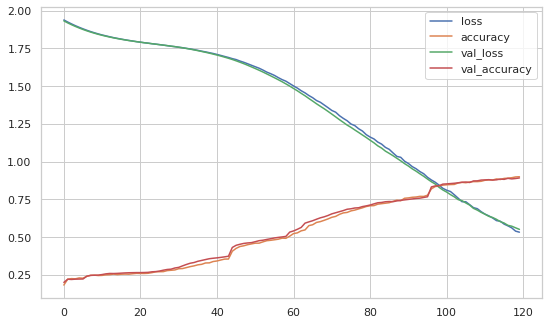

In [ ]:
#loop through dictionary of imported models and generate results for each model. then save the best trained model of epochs.
batch_size=32
epochs=100
for i in modeldict:
  base_model2 = modeldict[i] #Select Model from dictionary loop
  # create a custom top classifier
  x = base_model2.output 
  x = Dense(1024, activation='relu')(x)#Have the added layer
  predictions = Dense( 7, activation='softmax')(x)#Add prediction layer ontop of the first added layer
  model2= Model(inputs=base_model2.inputs, outputs=predictions)
  model2.compile(tensorflow.keras.optimizers.SGD(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
  #model2.summary()
  callbacks = [EarlyStopping(monitor='val_loss', patience=25),#Establish early stopping to prevent overfitting
        ModelCheckpoint(filepath='{}.h5'.format(i), monitor='val_accuracy', save_best_only=True)] #Download Best model based on validation accuracy
  History = model2.fit(datagen.flow(x_train,y_train, batch_size=batch_size), #Train model and get results
                                epochs = epochs, validation_data = (x_test,y_test),callbacks=callbacks,
                                verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
  files.download('{}.h5'.format(i))#Download trained model
  pd.DataFrame(History.history).plot(figsize=(8, 5))#Give Epoch Model Report
  plt.grid(True)
  plt.gca()
  plt.show()

## Predictions

In [ ]:
#### To predict images use the code below. 

In [ ]:
# The code below predicts classes on images by loading prebuilt models. 

In [ ]:
import cv2
import numpy as np
from keras.models import load_model
from sklearn.metrics import accuracy_score
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from google.colab.patches import cv2_imshow
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

In [ ]:
# Even though the above image has lot of plastic waste the model suggests that it is glass due to the trasperent nature of plastic as well as glass. 

In [ ]:
# Lets try to run another model with same image. 

In [ ]:
datagen.fit(x_test)

In [ ]:
Xception = load_model('/content/Xception.h5')
y_proba=Xception.predict(x_test)
y_proba=y_proba.round(2)
Threshold=0.5
for i in range(y_proba.shape[1]):
  for j in range(len(y_proba)):
    if y_proba[j,i]>=Threshold:
      y_proba[j,i]=1
    else:
      y_proba[j,i]=0
#y_proba = np.argmax(y_proba, axis=1)
accuracy_score(y_proba,y_test)

0.7831325301204819

In [ ]:
ResNetModel = load_model('/content/ResNet50.h5')
y_proba=ResNetModel.predict(x_test)
y_proba=y_proba.round(2)
Threshold=0.5
for i in range(y_proba.shape[1]):
  for j in range(len(y_proba)):
    if y_proba[j,i]>=Threshold:
      y_proba[j,i]=1
    else:
      y_proba[j,i]=0
#y_proba = np.argmax(y_proba, axis=1)
accuracy_score(y_proba,y_test)

0.9672977624784854

In [ ]:
DenseNet201 = load_model('/content/DenseNet201.h5')
y_proba=DenseNet201.predict(x_test)
y_proba=y_proba.round(2)
Threshold=0.5
for i in range(y_proba.shape[1]):
  for j in range(len(y_proba)):
    if y_proba[j,i]>=Threshold:
      y_proba[j,i]=1
    else:
      y_proba[j,i]=0
#y_proba = np.argmax(y_proba, axis=1)
accuracy_score(y_proba,y_test)

0.8037865748709122

In [ ]:
MobileNet = load_model('/content/MobileNet.h5')
y_proba=MobileNet.predict(x_test)
y_proba=y_proba.round(2)
Threshold=0.5
for i in range(y_proba.shape[1]):
  for j in range(len(y_proba)):
    if y_proba[j,i]>=Threshold:
      y_proba[j,i]=1
    else:
      y_proba[j,i]=0
#y_proba = np.argmax(y_proba, axis=1)
accuracy_score(y_proba,y_test)

0.7779690189328744

In [ ]:
ResNet152V2 = load_model('/content/ResNet152V2.h5')
y_proba=ResNet152V2.predict(x_test)
y_proba=y_proba.round(2)
Threshold=0.5
for i in range(y_proba.shape[1]):
  for j in range(len(y_proba)):
    if y_proba[j,i]>=Threshold:
      y_proba[j,i]=1
    else:
      y_proba[j,i]=0
#y_proba = np.argmax(y_proba, axis=1)
accuracy_score(y_proba,y_test)

0.7796901893287436

In [ ]:
NASNetMobile = load_model('/content/NASNetMobile.h5')
y_proba=NASNetMobile.predict(x_test)
y_proba=y_proba.round(2)
Threshold=0.5
for i in range(y_proba.shape[1]):
  for j in range(len(y_proba)):
    if y_proba[j,i]>=Threshold:
      y_proba[j,i]=1
    else:
      y_proba[j,i]=0
#y_proba = np.argmax(y_proba, axis=1)
accuracy_score(y_proba,y_test)

0.7314974182444062

In [ ]:
# Mounts the drive to read models and images for prediction
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Initiated the labels and encodes with a Label Encoder
labels = ['cardboard', 'e_waste', 'glass' , 'medical', 'metal', 'paper','plastic']
le=LabelEncoder()
le.fit_transform(labels)

array([0, 1, 2, 3, 4, 5, 6])

#Challenging Google Images

in this section we test our best two models on random images from google. 

In [ ]:
# Predicts using the model and image loaded above.
def predict_on_img(img_path, model):
  prediction = model.predict(get_pre_processed_img(img_path))
  print('Prediction', le.inverse_transform(np.argmax(prediction,axis=1)))
  print('Confidence Array of the model', prediction)
  print('Class Labels', labels)

In [ ]:
def get_pre_processed_img(img_path):
  # Reads the image.
  image = cv2.imread(img_path,cv2.IMREAD_COLOR)
  image = cv2.resize(image, (224,224))
  cv2_imshow(image)
  # Creates np aray from the images and normalizes the values. 
  img_processed = []
  img_processed.append(np.array(image))
  img_processed = np.array(img_processed)
  img_processed = img_processed/255
  return img_processed


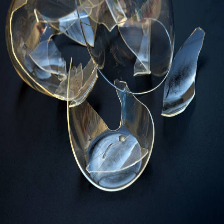

Prediction ['glass']
Confidence Array of the model [[0.04 0.04 0.72 0.06 0.11 0.03 0.01]]
Class Labels ['cardboard', 'e_waste', 'glass', 'medical', 'metal', 'paper', 'plastic']


In [ ]:
predict_on_img('/content/BrokenGlass.jpg', Xception)

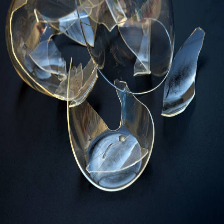

Prediction ['glass']
Confidence Array of the model [[0.01 0.02 0.9  0.01 0.05 0.01 0.  ]]
Class Labels ['cardboard', 'e_waste', 'glass', 'medical', 'metal', 'paper', 'plastic']


In [ ]:
predict_on_img('/content/BrokenGlass.jpg', ResNetModel)

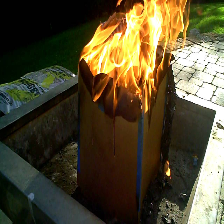

Prediction ['cardboard']
Confidence Array of the model [[0.77 0.04 0.04 0.04 0.07 0.04 0.  ]]
Class Labels ['cardboard', 'e_waste', 'glass', 'medical', 'metal', 'paper', 'plastic']


In [ ]:
predict_on_img('/content/maxresdefault.jpg', ResNetModel)

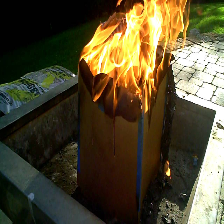

Prediction ['e_waste']
Confidence Array of the model [[0.21 0.32 0.1  0.26 0.08 0.02 0.  ]]
Class Labels ['cardboard', 'e_waste', 'glass', 'medical', 'metal', 'paper', 'plastic']


In [ ]:
predict_on_img('/content/maxresdefault.jpg', Xception)

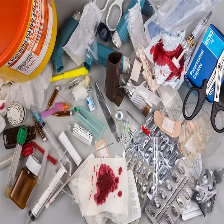

Prediction ['medical']
Confidence Array of the model [[0.02 0.06 0.06 0.66 0.13 0.07 0.  ]]
Class Labels ['cardboard', 'e_waste', 'glass', 'medical', 'metal', 'paper', 'plastic']


In [ ]:
predict_on_img('/content/87415.webp', Xception)


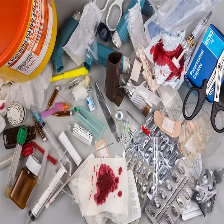

Prediction ['medical']
Confidence Array of the model [[0.01 0.02 0.02 0.9  0.04 0.01 0.  ]]
Class Labels ['cardboard', 'e_waste', 'glass', 'medical', 'metal', 'paper', 'plastic']


In [ ]:
predict_on_img('/content/87415.webp', ResNetModel)